In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy import distance
import folium
import datetime as dt

csv_file = '../Data_Cleanup/outCSV/Station_ID_with_AvgIdleDaytimesDays_and_lonlat.csv'
df = pd.read_csv(csv_file)

In [4]:
df["idle_time"] = pd.to_timedelta(df["idle_time"])

#####################################Important
sorted_df = df.sort_values(by="idle_time", ascending=False)
sorted_df.head()

,end_station_id,idle_time,morgens,vormittags,mittags,nachmittags,abends,nachts,monday,tuesday,wednesday,thursday,friday,saturday,sunday,end_station_lat,end_station_lon
215,4403,293 days 23:18:23.586206896,43,90,113,43,43,43,42,42,42,43,43,43,136,[33.943359],[-118.248238]
156,4321,16 days 08:02:23.571428571,13,15,16,14,11,12,3,6,6,5,9,5,5,[34.031399],[-118.453629]
31,3039,16 days 06:44:38.608695652,36,59,93,63,34,34,34,34,34,34,34,34,113,[34.024479],[-118.393867]
191,4363,13 days 15:34:22.466666666,12,13,12,8,11,12,6,6,9,10,10,9,8,[34.03046],[-118.389099]
239,4432,10 days 23:02:06.598639455,87,94,110,120,91,76,52,61,66,46,56,53,56,[34.139568],[-118.362251]


We can see that the station 4403 has an unnormal idle_time, my first idea would be to filter the original data by the station id and plot the idle_time of each trip against the start time of the trip

C:\Users\moham\AppData\Local\Temp\ipykernel_11732\2476255651.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)
C:\Users\moham\AppData\Local\Temp\ipykernel_11732\2476255651.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)


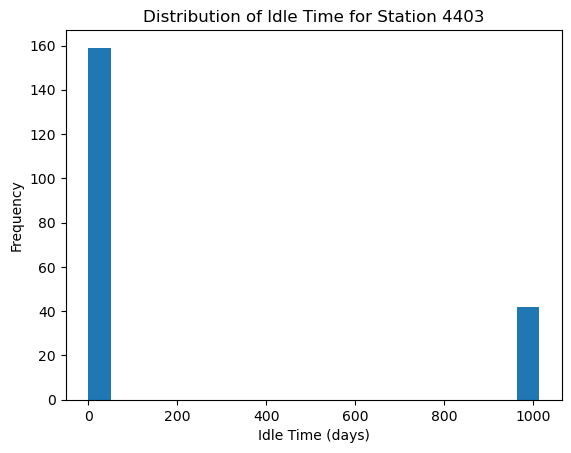

In [3]:
#######################################Important
full_data = pd.read_csv("../Data_Cleanup/outCSV/Metro_Set_DayAndDayTimes.csv", index_col=0)

# Filter the rows for the station with ID 4403
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]

# Convert the idle_time column to numeric values in days
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)

# Create a histogram of idle_time values
plt.hist(station_data['idle_time'], bins=20)
plt.xlabel('Idle Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Time for Station 4403')
plt.show()


Looking at the Histogramm we can see that we have around 40 rows that has more than 1000 days in idle time.

Lets take a better look at those 40 trips

In [4]:
#########Important

station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['start_time'] = pd.to_datetime(station_data["start_time"])
station_data['end_time'] = pd.to_datetime(station_data["end_time"])

# Convert 'idle_time' column to Timedelta
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time'])
# Filter the rows for the station with ID 4403 and idle_time over 1000 days
long_idle_trips = station_data[station_data["idle_time"] > pd.Timedelta(days=1000)]
# Sort the trips by end_time in ascending order
long_idle_trips = long_idle_trips.sort_values('end_time')

# Initialize an empty DataFrame to store the comparison results
comparison_results = pd.DataFrame(columns=['Trip', 'End Time', 'Next Start Time'])

# Iterate over the rows of the long_idle_trips DataFrame
for index, row in long_idle_trips.iterrows():
    end_time = row['end_time']
    for index, row in station_data.iterrows():
        if row["start_time"] > end_time:
            next_start_time = row["start_time"]
    comparison_results = pd.concat([comparison_results, pd.DataFrame({'Trip': [index], 'End Time': [end_time], 'Next Start Time': [next_start_time]})], ignore_index=True)

# Print the comparison results
print(comparison_results)
print(sorted_df.info())

C:\Users\moham\AppData\Local\Temp\ipykernel_11732\607701573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['start_time'] = pd.to_datetime(station_data["start_time"])
C:\Users\moham\AppData\Local\Temp\ipykernel_11732\607701573.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['end_time'] = pd.to_datetime(station_data["end_time"])
C:\Users\moham\AppData\Local\Temp\ipykernel_11732\607701573.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

      Trip            End Time     Next Start Time
0   944376 2020-02-23 13:58:00 2022-12-04 14:54:00
1   944376 2020-02-23 13:58:00 2022-12-04 14:54:00
2   944376 2020-02-23 14:00:00 2022-12-04 14:54:00
3   944376 2020-02-23 14:02:00 2022-12-04 14:54:00
4   944376 2020-02-23 14:02:00 2022-12-04 14:54:00
5   944376 2020-02-23 14:05:00 2022-12-04 14:54:00
6   944376 2020-02-23 14:07:00 2022-12-04 14:54:00
7   944376 2020-02-23 14:07:00 2022-12-04 14:54:00
8   944376 2020-02-23 14:09:00 2022-12-04 14:54:00
9   944376 2020-02-23 14:10:00 2022-12-04 14:54:00
10  944376 2020-02-23 14:10:00 2022-12-04 14:54:00
11  944376 2020-02-23 14:10:00 2022-12-04 14:54:00
12  944376 2020-02-23 14:11:00 2022-12-04 14:54:00
13  944376 2020-02-23 14:11:00 2022-12-04 14:54:00
14  944376 2020-02-23 14:14:00 2022-12-04 14:54:00
15  944376 2020-02-23 14:15:00 2022-12-04 14:54:00
16  944376 2020-02-23 14:16:00 2022-12-04 14:54:00
17  944376 2020-02-23 14:18:00 2022-12-04 14:54:00
18  944376 2020-02-23 14:18:00 

It seems tht there has been a huge break in the usage in this station, let try to find it.

Looking at the data we can see that no one used the station between 2020-02-23 15:09:00 and 2022-12-04 14:54:00

C:\Users\moham\AppData\Local\Temp\ipykernel_11732\3071390539.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_stations["end_station_id"] = top_20_stations["end_station_id"].astype(str)


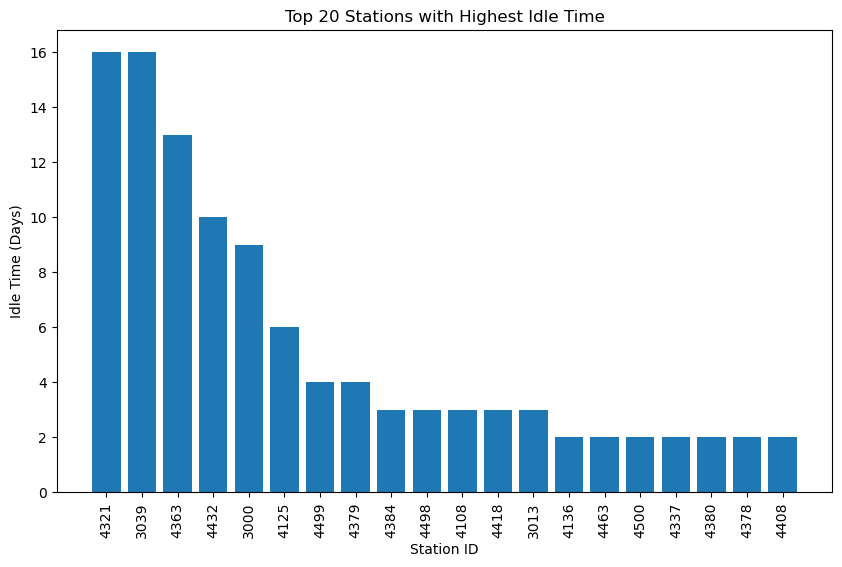

In [5]:
sorted_df['end_station_lat'] = sorted_df['end_station_lat'].str[1:-1].astype(np.float64)
sorted_df['end_station_lon'] = sorted_df['end_station_lon'].str[1:-1].astype(np.float64)



# Filter the sorted_df to exclude outliers with more than 30 days of idle time
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=30)]

# Take the top 20 stations with the highest idle time
top_20_stations = filtered_df.head(20)

# Convert the end_station_id to string
top_20_stations["end_station_id"] = top_20_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_20_stations["end_station_id"], top_20_stations["idle_time"].dt.days)

# Set the chart title and axis labels
plt.title("Top 20 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_11732\1460120418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_20_stations["end_station_id"] = bottom_20_stations["end_station_id"].astype(str)


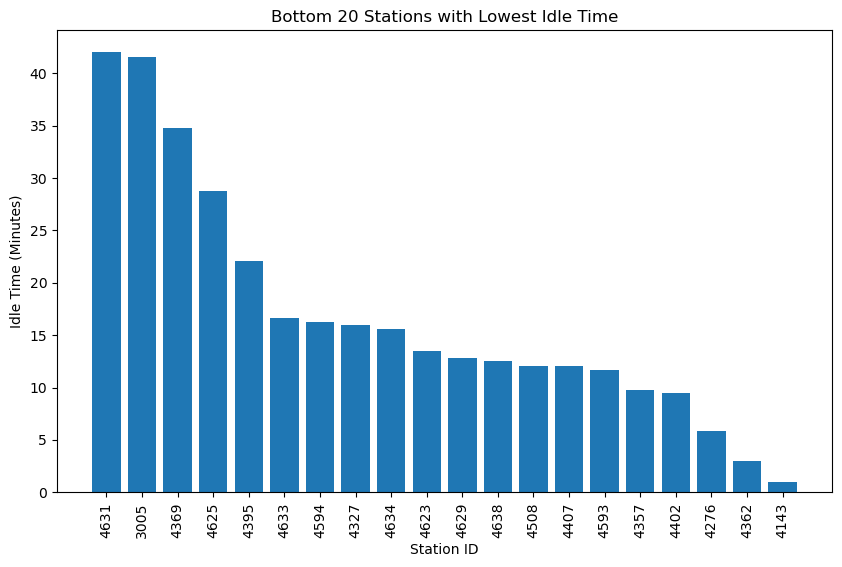

In [6]:
# Take the top 10 stations with the highest idle time
bottom_20_stations = filtered_df.tail(20)

# Convert the end_station_id to string
bottom_20_stations["end_station_id"] = bottom_20_stations["end_station_id"].astype(str)

# Plot the vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(bottom_20_stations["end_station_id"], bottom_20_stations["idle_time"].dt.total_seconds()/60)

# Set the chart title and axis labels
plt.title("Bottom 20 Stations with Lowest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Minutes)")

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.show()


To approach the problem methodically. We will sort our data by the average idle_time of the stations. We wil split our data into two halves (top_50_percent and bottom_50_percent). We will look for the average idle_time for each half. the candidate stations (to be either closed or expanded) will be either above the top_avg or below the bottom_avg respectively.

In [7]:
filtered_df.count()

end_station_id     393
idle_time          393
morgens            393
vormittags         393
mittags            393
nachmittags        393
abends             393
nachts             393
monday             393
tuesday            393
wednesday          393
thursday           393
friday             393
saturday           393
sunday             393
end_station_lat    393
end_station_lon    393
dtype: int64

Since we have 393 Stations. We will divide them into two halves.

In [8]:
top_50_percent = filtered_df.head(197)
bottom_50_percent = filtered_df.tail(196)

In [9]:

avg_idle_time_top_50 = top_50_percent["idle_time"].mean()
avg_idle_time_bottom_50 = bottom_50_percent["idle_time"].mean()

#Our Candidates in the top half
over_top_avg_df = top_50_percent[top_50_percent["idle_time"] >= avg_idle_time_top_50]

#Our Candidates in the bottom half
under_bottom_avg_df = bottom_50_percent[bottom_50_percent["idle_time"] <= avg_idle_time_bottom_50]

To further filter the candidates we decides to look for the neighboring stations of the candidates. The Radius a station has to be in is 500 m to considered a neighbor. We will take the average of the idle_time of the neighboring stations to see how our candidates is performing regarding its neighbors. if a candidate from the top half has a higher idle_time than the avg_neighbor_idle_time and has at least 2 neighbor, it should be closed. On the other hand if a candidate from the bottom half has a lower idle_time than the avg_neighbor_idle_time and has less than 2 neighbours, it should be expanded.

In [10]:
over_top_avg_df["neighboring_stations"] = None
over_top_avg_df["avg_neighbor_idle_time"] = None
for i, row in over_top_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)


    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])
    over_top_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    over_top_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)


under_bottom_avg_df["neighboring_stations"] = None
under_bottom_avg_df["avg_neighbor_idle_time"] = None

for i, row in under_bottom_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)


    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])


    under_bottom_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    under_bottom_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)

C:\Users\moham\AppData\Local\Temp\ipykernel_11732\2086466528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["neighboring_stations"] = None
C:\Users\moham\AppData\Local\Temp\ipykernel_11732\2086466528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["avg_neighbor_idle_time"] = None
C:\Users\moham\AppData\Local\Temp\ipykernel_11732\2086466528.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [11]:
to_be_removed = []
for i, zeile in over_top_avg_df.iterrows():
        if zeile["idle_time"] > zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) > 2:
            to_be_removed.append(zeile["end_station_id"])


to_be_expanded = []
for i, zeile in under_bottom_avg_df.iterrows():
        if zeile["idle_time"] < zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) =< 2:
            to_be_expanded.append(zeile["end_station_id"])



print(to_be_removed)
print(len(to_be_removed))
print(to_be_expanded)
print(len(to_be_expanded))




[3039, 4363, 3000, 4379, 4384, 4418, 4463, 4500, 4337, 4380, 4408, 4394, 4338, 4332, 4373, 4213, 4374, 4385, 4341, 4417, 4413, 4598, 4462]
23
[4587, 4632, 4626, 3014, 4594, 4327, 4623, 4629, 4276, 4362]
10


That would be the list of the Stations that need to either closed or expanded.

In [12]:
# Latitude and Longitude coordinates of Los Angeles
la_coordinates = (34.0522, -118.2437)

# Create a folium map centered on Los Angeles
map_la = folium.Map(location=la_coordinates, zoom_start=11)

for index, row in filtered_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    
    
    if station_id in to_be_expanded:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="green")).add_to(map_la)
    elif station_id in to_be_removed:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="red")).add_to(map_la)
    else:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)]).add_to(map_la)
map_la